In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict
import logging
import re
import pandas as pd
from collections import Counter

from neuralnetlib.layers import MultiHeadAttention, PositionalEncoding, AddNorm, FeedForward, TransformerEncoderLayer, TransformerDecoderLayer, Embedding
from neuralnetlib.preprocessing import PCA, Tokenizer, one_hot_encode, pad_sequences

logging.getLogger('matplotlib').setLevel(logging.ERROR)



Debugging Embedding Layer


INFO:embedding_debug:Starting embedding forward pass
INFO:embedding_debug:Initializing embedding weights



French Embedding Layer:
------------------------------

Embedding Usage Statistics:
  unique_tokens: 2250
  total_tokens: 95000
  most_common_tokens: [(0, 321), (2, 844), (3, 1000), (4, 1000), (5, 81486)]
  unused_tokens: 1
  special_token_usage: {'token_0': 81486, 'token_1': 0, 'token_2': 1000, 'token_3': 1000}

Token Distribution:
  Total tokens: 95000
  Unique tokens: 2250
  Most common tokens: [(0, 81486), (2, 1000), (3, 1000), (4, 844), (5, 321)]
  Special tokens usage:
    Token 0: 81486
    Token 1: 0
    Token 2: 1000
    Token 3: 1000

Visualizing French Embeddings:


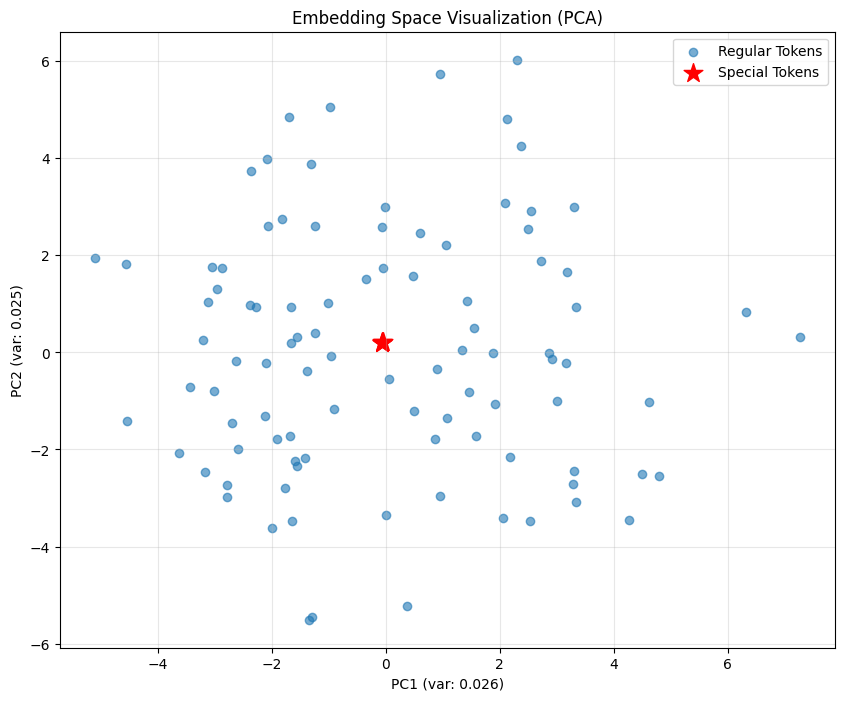

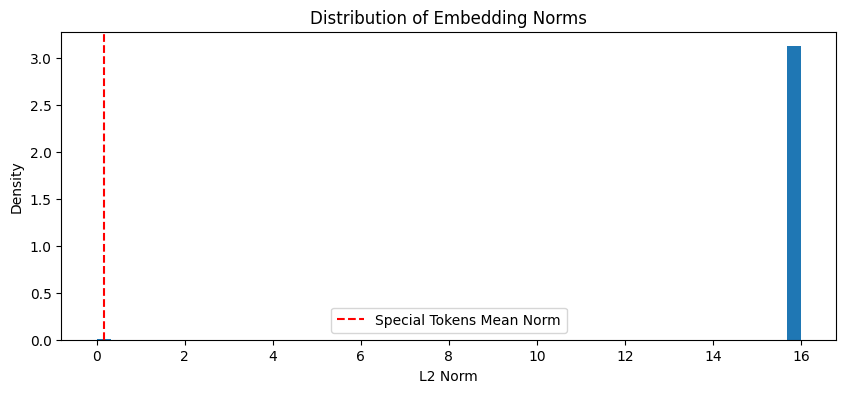

INFO:embedding_debug:Starting embedding forward pass
INFO:embedding_debug:Initializing embedding weights



English Embedding Layer:
------------------------------

Visualizing English Embeddings:


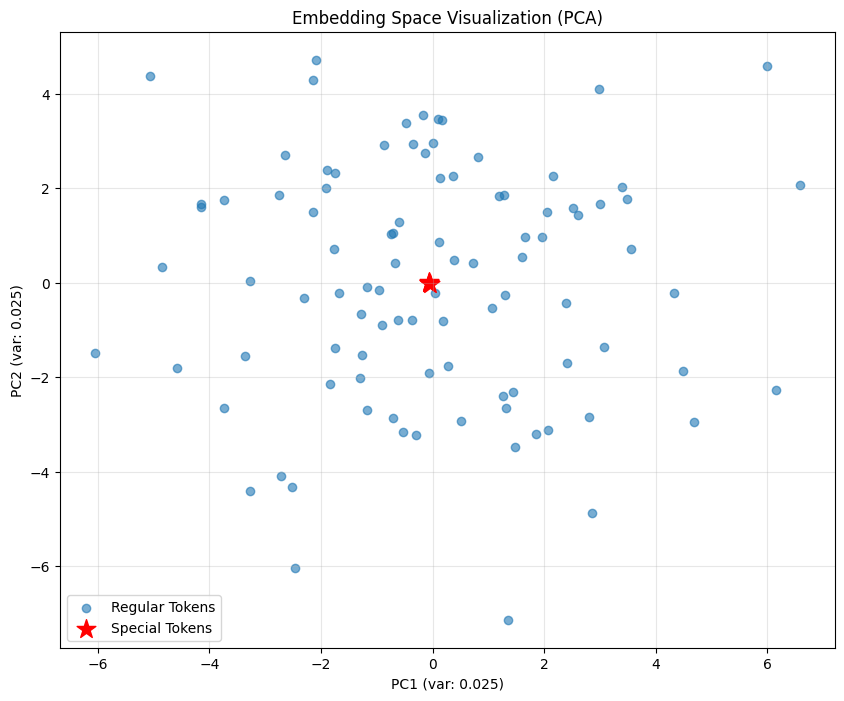

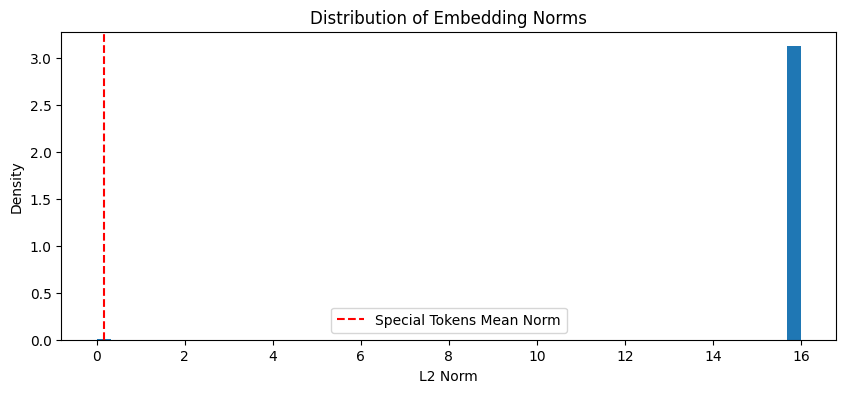

INFO:embedding_debug:Starting embedding backward pass
INFO:embedding_debug:Starting embedding backward pass



Gradient Statistics:
------------------------------

French Embedding Gradients:

weight_gradients:
  mean: 1.3649876713788839e-06
  std: 0.001317322278626105
  max: 0.00808080815589089
  norm: 0.9999999999999992
  zero_ratio: 0.000888494002665482

special_token_gradients:
  token_0: 0.0
  token_1: 0.0
  token_2: 0.00075888138020374
  token_3: 0.0007538753024567253

English Embedding Gradients:

weight_gradients:
  mean: -2.184994908401882e-06
  std: 0.0014088571098158087
  max: 0.007696058639254244
  norm: 0.9999999999999997
  zero_ratio: 0.0010162601626016261

special_token_gradients:
  token_0: 0.0
  token_1: 0.0
  token_2: 0.0008584963588625617
  token_3: 0.0008448679895237302


In [2]:
class DebugEmbedding(Embedding):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("embedding_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape,
            'norm': float(np.linalg.norm(tensor))
        }
        self.debug_info[name] = stats
        return stats

    def analyze_embedding_usage(self, input_data: np.ndarray) -> dict:
        unique_tokens, counts = np.unique(input_data, return_counts=True)
        usage_stats = {
            'unique_tokens': len(unique_tokens),
            'total_tokens': int(np.prod(input_data.shape)),
            'most_common_tokens': [
                (int(token), int(count)) 
                for token, count in zip(unique_tokens[np.argsort(-counts)[:5]], 
                                     np.sort(counts)[-5:])
            ],
            'unused_tokens': int(np.sum(np.bincount(input_data.flatten(), 
                                                   minlength=self.input_dim) == 0)),
            'special_token_usage': {
                f'token_{i}': int(np.sum(input_data == i))
                for i in range(4)  # Special tokens [0,1,2,3]
            }
        }
        self.debug_info['embedding_usage'] = usage_stats
        return usage_stats

    def visualize_embeddings(self, num_tokens: int = 100) -> None:
        if self.weights is None:
            self.logger.warning("No embeddings available to visualize")
            return
            
        tokens_to_viz = min(num_tokens, self.input_dim)
        embeddings = self.weights[:tokens_to_viz]
        
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 8))
        
        special_tokens = embeddings_2d[:4]
        regular_tokens = embeddings_2d[4:]
        
        plt.scatter(regular_tokens[:, 0], regular_tokens[:, 1], 
                   alpha=0.6, label='Regular Tokens')
        plt.scatter(special_tokens[:, 0], special_tokens[:, 1], 
                   marker='*', s=200, c='red', label='Special Tokens')
        
        plt.title('Embedding Space Visualization (PCA)')
        plt.xlabel(f'PC1 (var: {pca.explained_variance_ratio[0]:.3f})')
        plt.ylabel(f'PC2 (var: {pca.explained_variance_ratio[1]:.3f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        plt.figure(figsize=(10, 4))
        norms = np.linalg.norm(self.weights, axis=1)
        plt.hist(norms, bins=50, density=True)
        plt.axvline(norms[:4].mean(), color='r', linestyle='--', 
                   label='Special Tokens Mean Norm')
        plt.title('Distribution of Embedding Norms')
        plt.xlabel('L2 Norm')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    def analyze_gradient_statistics(self) -> dict:
        if not hasattr(self, 'd_weights'):
            return {}
            
        grad_stats = {
            'weight_gradients': {
                'mean': float(np.mean(self.d_weights)),
                'std': float(np.std(self.d_weights)),
                'max': float(np.max(np.abs(self.d_weights))),
                'norm': float(np.linalg.norm(self.d_weights)),
                'zero_ratio': float(np.mean(self.d_weights == 0))
            },
            'special_token_gradients': {
                f'token_{i}': float(np.linalg.norm(self.d_weights[i]))
                for i in range(4)
            }
        }
        self.debug_info['gradient_stats'] = grad_stats
        return grad_stats

    def initialize_weights(self):
        self.logger.info("Initializing embedding weights")
        super().initialize_weights()
        self.analyze_tensor(self.weights, 'initial_weights')
        
        special_token_stats = {
            f'token_{i}_norm': float(np.linalg.norm(self.weights[i]))
            for i in range(4)
        }
        self.debug_info['special_token_init'] = special_token_stats

    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        self.logger.info("Starting embedding forward pass")
        
        self.analyze_tensor(input_data, 'input')
        self.analyze_embedding_usage(input_data)
        
        output = super().forward_pass(input_data)
        
        self.analyze_tensor(output, 'output')
        self.check_numerical_stability(output, 'output')
        
        return output

    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting embedding backward pass")
        
        self.analyze_tensor(output_error, 'output_error')
        
        grad = super().backward_pass(output_error)
        
        self.analyze_gradient_statistics()
        
        return grad


def debug_embedding_layer(dataset_path: str = "dataset.tsv", limit: int = 1000, visualize: bool = True) -> None:
    print("\nDebugging Embedding Layer")
    print("=" * 50)
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    fr_embedding = DebugEmbedding(
        input_dim=len(fr_tokenizer.word_index),
        output_dim=256,
        input_length=None
    )
    
    en_embedding = DebugEmbedding(
        input_dim=len(en_tokenizer.word_index),
        output_dim=256,
        input_length=None
    )
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    print("\nFrench Embedding Layer:")
    print("-" * 30)
    fr_output = fr_embedding.forward_pass(X)
    
    print("\nEmbedding Usage Statistics:")
    for name, stats in fr_embedding.debug_info['embedding_usage'].items():
        print(f"  {name}: {stats}")
    
    print("\nToken Distribution:")
    token_counts = Counter(X.flatten())
    print(f"  Total tokens: {sum(token_counts.values())}")
    print(f"  Unique tokens: {len(token_counts)}")
    print(f"  Most common tokens: {token_counts.most_common(5)}")
    print(f"  Special tokens usage:")
    for i in range(4):
        print(f"    Token {i}: {token_counts[i]}")
    
    if visualize:
        print("\nVisualizing French Embeddings:")
        fr_embedding.visualize_embeddings()
    
    print("\nEnglish Embedding Layer:")
    print("-" * 30)
    en_output = en_embedding.forward_pass(y)
    
    if visualize:
        print("\nVisualizing English Embeddings:")
        en_embedding.visualize_embeddings()
    
    fr_grad = np.random.normal(0, 0.1, fr_output.shape)
    en_grad = np.random.normal(0, 0.1, en_output.shape)
    
    fr_embedding.backward_pass(fr_grad)
    en_embedding.backward_pass(en_grad)
    
    print("\nGradient Statistics:")
    print("-" * 30)
    for lang, emb in [("French", fr_embedding), ("English", en_embedding)]:
        print(f"\n{lang} Embedding Gradients:")
        grad_stats = emb.debug_info.get('gradient_stats', {})
        for category, stats in grad_stats.items():
            print(f"\n{category}:")
            for metric, value in stats.items():
                print(f"  {metric}: {value}")
    
    return fr_embedding, en_embedding, fr_tokenizer, en_tokenizer

# Test avec votre dataset
fr_emb, en_emb, fr_tok, en_tok = debug_embedding_layer(
    dataset_path="dataset.tsv",
    limit=1000,
    visualize=True
)

Preparing data for attention layer debugging...


INFO:attention_debug:Starting forward pass
DEBUG:attention_debug:query shape: (32, 8, 95, 64)
DEBUG:attention_debug:key shape: (32, 8, 95, 64)
DEBUG:attention_debug:value shape: (32, 8, 95, 64)



Testing Self-Attention (French)...

Testing Self-Attention (French)...


INFO:attention_debug:Forward pass completed
DEBUG:attention_debug:final_output shape: (32, 95, 512)


French Self-Attention Output Shape: (32, 95, 512)

French Self-Attention Debug Summary:
-------------
Shape Information:
query_shape: (32, 8, 95, 64)
key_shape: (32, 8, 95, 64)
value_shape: (32, 8, 95, 64)
final_output_shape: (32, 95, 512)

Attention Statistics:
mean: 0.0105
std: 0.0312
max: 0.1726
min: 0.0000
sparsity: 0.8826
entropy: 2.3374

Visualizing French Self-Attention Pattern:


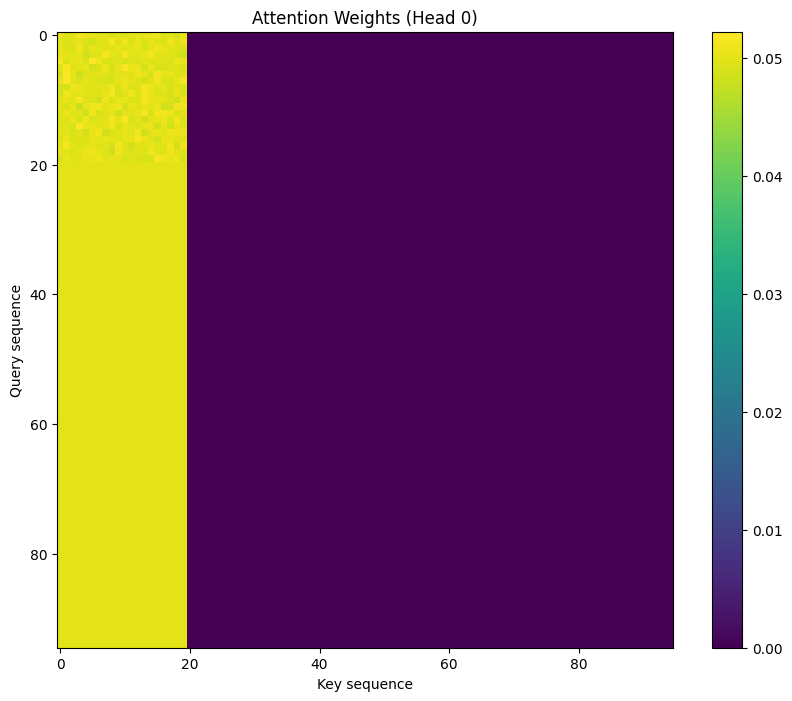

INFO:attention_debug:Starting forward pass
DEBUG:attention_debug:query shape: (32, 8, 95, 64)
DEBUG:attention_debug:key shape: (32, 8, 95, 64)
DEBUG:attention_debug:value shape: (32, 8, 95, 64)



Testing Cross-Attention...


INFO:attention_debug:Forward pass completed
DEBUG:attention_debug:final_output shape: (32, 95, 512)


Cross-Attention Output Shape: (32, 95, 512)

Cross-Attention Debug Summary:
-------------

Attention Statistics:
mean: 0.0105
std: 0.0332
max: 0.2095
min: 0.0000
sparsity: 0.8957
entropy: 2.2183

Visualizing Cross-Attention Pattern:


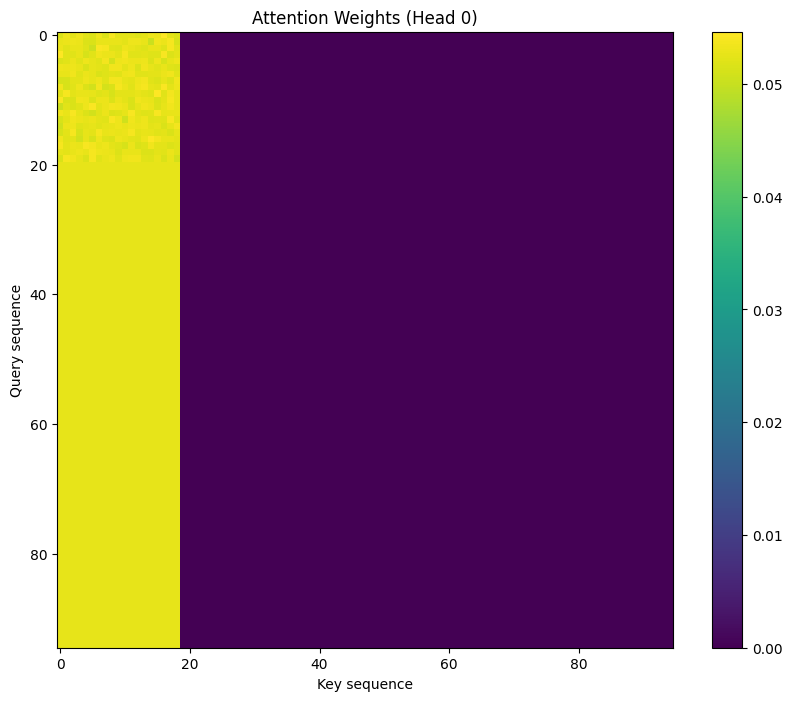

In [3]:
class DebugMultiHeadAttention(MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug_info = {}
        self.setup_logging()
        
    def setup_logging(self):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("attention_debug")
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def log_shape_info(self, tensor: np.ndarray, name: str) -> None:
        """Log shape information of tensors"""
        self.logger.debug(f"{name} shape: {tensor.shape}")
        self.debug_info[f"{name}_shape"] = tensor.shape

    def analyze_attention_scores(self, scores: np.ndarray, stage: str) -> None:
        """Analyser les scores avant le softmax"""
        self.debug_info[f'attention_scores_{stage}'] = {
            'mean': float(np.mean(scores)),
            'std': float(np.std(scores)),
            'max': float(np.max(scores)),
            'min': float(np.min(scores))
        }

    def analyze_attention_pattern(self, weights: np.ndarray) -> None:
        """Analyser les motifs d'attention"""
        # Analyse de la concentration par position
        position_focus = np.mean(weights, axis=(0, 1))  # Moyenne sur batch et heads
        self.debug_info['attention_pattern'] = {
            'position_entropy': float(-np.sum(position_focus * np.log(position_focus + 1e-10))),
            'max_position_weight': float(np.max(position_focus)),
            'position_std': float(np.std(position_focus))
        }
    
    def analyze_attention_weights(self, weights: np.ndarray) -> Dict:
        analysis = {
            'mean': float(np.mean(weights)),
            'std': float(np.std(weights)),
            'max': float(np.max(weights)),
            'min': float(np.min(weights)),
            'sparsity': float(np.mean(weights < 0.01)),  # % of weights near zero
            'entropy': float(-np.sum(weights * np.log(weights + 1e-10), axis=-1).mean())
        }
        self.debug_info['attention_stats'] = analysis
        return analysis
        
    def visualize_attention(self, head_idx: int = 0, batch_idx: int = 0) -> None:
        if self.attention_weights is None:
            self.logger.warning("No attention weights available for visualization")
            return
            
        weights = self.attention_weights[batch_idx, head_idx]
        plt.figure(figsize=(10, 8))
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'Attention Weights (Head {head_idx})')
        plt.xlabel('Key sequence')
        plt.ylabel('Query sequence')
        plt.show()
        
    def _scaled_dot_product_attention(self, query: np.ndarray, key: np.ndarray, 
                                        value: np.ndarray, mask: np.ndarray = None,
                                        training: bool = True) -> np.ndarray:
        self.log_shape_info(query, 'query')
        self.log_shape_info(key, 'key')
        self.log_shape_info(value, 'value')

        if self.normalize_attention:
            query_norm = np.sqrt(np.sum(query * query, axis=-1, keepdims=True) + 1e-6)
            key_norm = np.sqrt(np.sum(key * key, axis=-1, keepdims=True) + 1e-6)
            
            query_normalized = query / query_norm
            key_normalized = key / key_norm
            
            matmul_qk = np.matmul(query_normalized, np.transpose(key_normalized, (0, 1, 3, 2)))
        else:
            matmul_qk = np.matmul(query, np.transpose(key, (0, 1, 3, 2)))

        self.check_numerical_stability(matmul_qk, 'QK matmul')

        d_k = key.shape[-1]
        
        scaling_factor = np.sqrt(d_k)
        scaled_attention_logits = matmul_qk / scaling_factor
        
        self.check_numerical_stability(scaled_attention_logits, 'scaled_attention_logits')

        MASKING_VALUE = -1e9
        if mask is not None:
            scaled_attention_logits += (mask * MASKING_VALUE)
        
        self.check_numerical_stability(scaled_attention_logits, 'scaled_attention_logits with mask')
        
        attention_weights = self._softmax_with_mask(scaled_attention_logits, mask)
        self.attention_weights = attention_weights
        
        self.check_numerical_stability(attention_weights, 'attention_weights')

        self.analyze_attention_weights(attention_weights)

        output = np.matmul(attention_weights, value)
        
        self.check_numerical_stability(output, 'attention_output')
        
        return output
        
    def forward_pass(self, inputs: np.ndarray | Tuple[np.ndarray, ...], 
                    mask: Optional[np.ndarray] = None,
                    training: bool = True) -> np.ndarray:
        """Override with debugging"""
        self.logger.info("Starting forward pass")
        self.debug_info.clear()
        
        output = super().forward_pass(inputs, mask, training)
        
        self.logger.info("Forward pass completed")
        self.log_shape_info(output, 'final_output')
        
        return output
        
    def get_debug_summary(self) -> Dict:
        if not self.debug_info:
            self.logger.warning("No debug information available")
            return {}
            
        summary = {
            'shapes': {k: v for k, v in self.debug_info.items() if 'shape' in k},
            'attention_stats': self.debug_info.get('attention_stats', {}),
        }
        return summary

def debug_attention_layer(attention_layer: DebugMultiHeadAttention,
                         dataset_path: str = "dataset.tsv",
                         limit: int = 1000,
                         embedding_dim: int = 512) -> None:
    print("Preparing data for attention layer debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    fr_embed = embed_fr.forward_pass(X[:32])
    en_embed = embed_en.forward_pass(y[:32])
    
    print("\nTesting Self-Attention (French)...")
    fr_mask = (X[:32] == fr_tokenizer.PAD_IDX)
    fr_mask = fr_mask[:, np.newaxis, np.newaxis, :]  # Shape: (batch, 1, 1, seq_len)
    fr_mask = np.tile(fr_mask, (1, attention_layer.num_heads, max_seq_len, 1))  # Shape: (batch, heads, seq_len, seq_len)

    print("\nTesting Self-Attention (French)...")
    fr_output = attention_layer.forward_pass(fr_embed, mask=fr_mask)
    print(f"French Self-Attention Output Shape: {fr_output.shape}")
    debug_summary = attention_layer.get_debug_summary()
    
    print("\nFrench Self-Attention Debug Summary:")
    print("-------------")
    print("Shape Information:")
    for name, shape in debug_summary['shapes'].items():
        print(f"{name}: {shape}")
        
    print("\nAttention Statistics:")
    for metric, value in debug_summary['attention_stats'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nVisualizing French Self-Attention Pattern:")
    attention_layer.visualize_attention(head_idx=0, batch_idx=0)
    
    print("\nTesting Cross-Attention...")
    cross_mask = (y[:32] == en_tokenizer.PAD_IDX)
    cross_mask = cross_mask[:, np.newaxis, np.newaxis, :]
    cross_mask = np.tile(cross_mask, (1, attention_layer.num_heads, max_seq_len, 1))

    cross_output = attention_layer.forward_pass((fr_embed, en_embed, en_embed), mask=cross_mask)
    print(f"Cross-Attention Output Shape: {cross_output.shape}")
    
    debug_summary = attention_layer.get_debug_summary()
    print("\nCross-Attention Debug Summary:")
    print("-------------")
    print("\nAttention Statistics:")
    for metric, value in debug_summary['attention_stats'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nVisualizing Cross-Attention Pattern:")
    attention_layer.visualize_attention(head_idx=0, batch_idx=0)
    
    return attention_layer

debug_attention = DebugMultiHeadAttention(
    num_heads=8,
    key_dim=64,
    dropout_rate=0.1,
    normalize_attention=True
)

attention = debug_attention_layer(
    debug_attention,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)

INFO:positional_encoding_debug:Building sinusoidal encodings...



Debugging Sinusoidal Positional Encoding


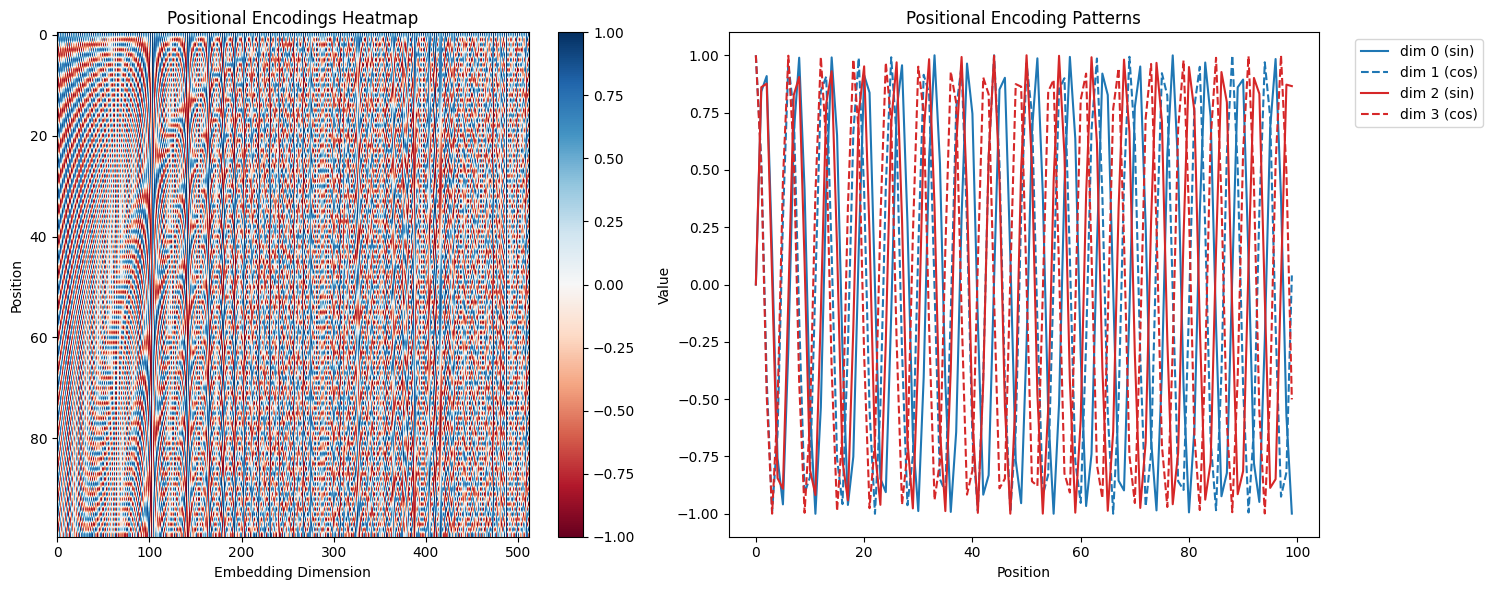

INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (2, 50, 512)
INFO:positional_encoding_debug:Building sinusoidal encodings...



Frequency Analysis:
-----------------

freq_range:
  min: 0.0000
  max: 99.0000
  mean: 36.7383

geometric_ratio:
  mean: 1.0366
  std: 0.0000

Encoding Statistics:
-------------------
mean: 0.0069
std: 0.7071
max: 1.0000
min: -1.0000

Forward Pass Statistics:
----------------------
input_mean: -0.0008
input_std: 1.0021
output_mean: 0.0122
output_std: 1.2262
encoding_contribution: 0.7929

Debugging Trainable Positional Encoding


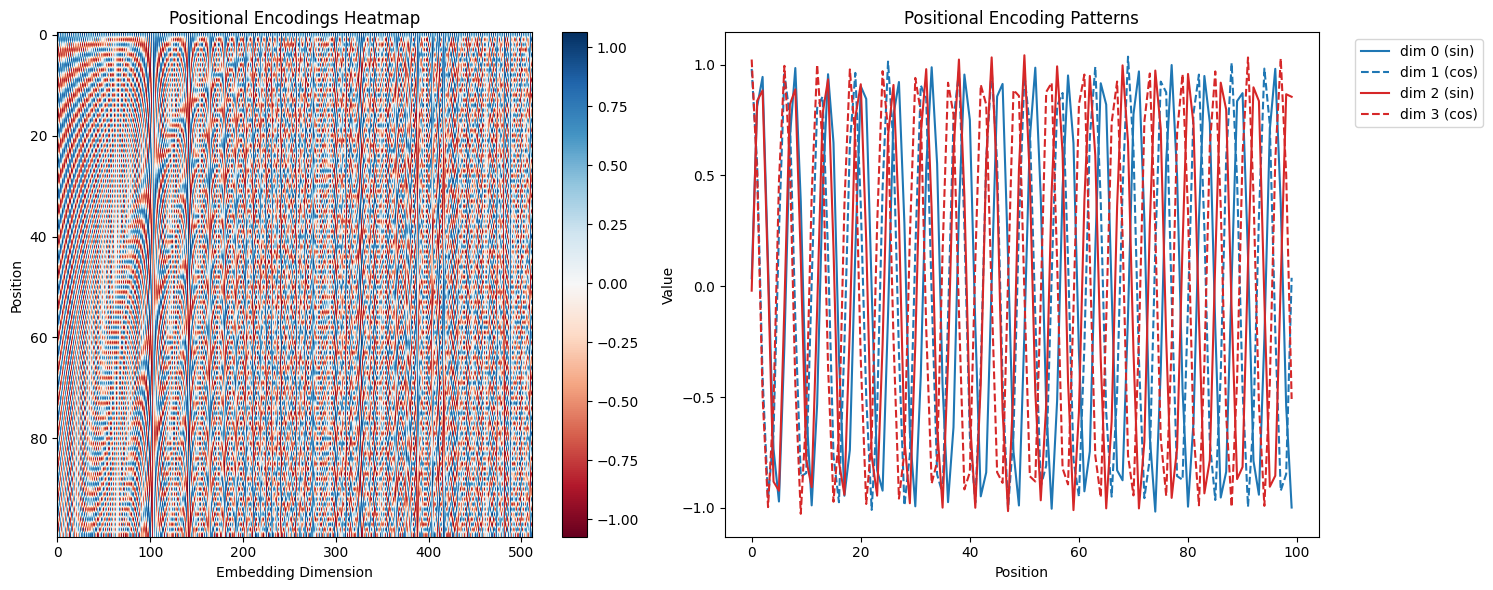

INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (2, 50, 512)



Frequency Analysis:
-----------------

freq_range:
  min: 0.0000
  max: 98.0000
  mean: 34.3047

Encoding Statistics:
-------------------
mean: 0.0069
std: 0.7071
max: 1.0000
min: -1.0000

Forward Pass Statistics:
----------------------
input_mean: -0.0008
input_std: 1.0021
output_mean: 0.0121
output_std: 1.2266
encoding_contribution: 0.7932


In [4]:
class DebugPositionalEncoding(PositionalEncoding):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("positional_encoding_debug")
        self.debug_info = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def visualize_encodings(self) -> None:
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        im = plt.imshow(self.weights[0], aspect='auto', cmap='RdBu')
        plt.colorbar(im)
        plt.title('Positional Encodings Heatmap')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Position')
        
        plt.subplot(1, 2, 2)
        colors = plt.cm.tab10(np.linspace(0, 1, 4))
        for i, color in zip(range(0, min(4, self.embedding_dim), 2), colors):
            plt.plot(self.weights[0, :, i], 
                    label=f'dim {i} (sin)', 
                    linestyle='-',
                    color=color)
            plt.plot(self.weights[0, :, i+1], 
                    label=f'dim {i+1} (cos)', 
                    linestyle='--',
                    color=color)
        plt.title('Positional Encoding Patterns')
        plt.xlabel('Position')
        plt.ylabel('Value')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def analyze_frequency_components(self) -> Dict:
        analysis = {}
        
        freq_spectrum = np.abs(np.fft.fft(self.weights[0], axis=0))
        dominant_freqs = np.argmax(freq_spectrum, axis=0)
        
        analysis['freq_range'] = {
            'min': float(np.min(dominant_freqs)),
            'max': float(np.max(dominant_freqs)),
            'mean': float(np.mean(dominant_freqs))
        }
        
        if not self.trainable:
            expected_freqs = 1 / np.power(10000.0, 
                                        np.arange(0, self.embedding_dim, 2) / self.embedding_dim)
            freq_ratio = expected_freqs[:-1] / expected_freqs[1:]
            analysis['geometric_ratio'] = {
                'mean': float(np.mean(freq_ratio)),
                'std': float(np.std(freq_ratio))
            }
            
        return analysis

    def _build_sinusoidal_encoding(self) -> None:
        self.logger.info("Building sinusoidal encodings...")
        
        position = np.arange(self.max_sequence_length)[:, np.newaxis]
        self.check_numerical_stability(position, 'position')
        
        div_term = np.power(
            10000.0,
            np.arange(0, self.embedding_dim, 2, dtype=np.float32) / self.embedding_dim
        )
        self.check_numerical_stability(div_term, 'div_term')
        
        pe = np.zeros((self.max_sequence_length, self.embedding_dim), dtype=np.float32)
        
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.check_numerical_stability(pe, 'positional_encoding')
        
        self.weights = pe[np.newaxis, :, :]
        self.d_weights = np.zeros_like(self.weights)
        
        self.debug_info['div_term'] = div_term
        self.debug_info['pe_stats'] = {
            'mean': float(np.mean(pe)),
            'std': float(np.std(pe)),
            'max': float(np.max(pe)),
            'min': float(np.min(pe)),
            'wavelengths': 1 / div_term
        }
        
    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        self.logger.info("Starting forward pass")
        
        batch_size, seq_len, emb_dim = input_data.shape
        self.logger.debug(f"Input shape: ({batch_size}, {seq_len}, {emb_dim})")
        
        if seq_len > self.max_sequence_length:
            self.logger.error(f"Sequence length {seq_len} exceeds maximum {self.max_sequence_length}")
            raise ValueError(
                f"Input sequence length {seq_len} exceeds maximum length {self.max_sequence_length}"
            )
            
        pos_encoding = self.weights[:, :seq_len, :]
        self.check_numerical_stability(pos_encoding, 'pos_encoding')
        
        if batch_size > 1:
            pos_encoding = np.repeat(pos_encoding, batch_size, axis=0)
            
        if self.scale_embeddings:
            scaled_input = input_data
            self.check_numerical_stability(scaled_input, 'scaled_input')
            output = scaled_input + pos_encoding
        else:
            output = input_data + pos_encoding
            
        self.check_numerical_stability(output, 'output')
        
        # Store debug info
        self.debug_info['forward_stats'] = {
            'input_mean': float(np.mean(input_data)),
            'input_std': float(np.std(input_data)),
            'output_mean': float(np.mean(output)),
            'output_std': float(np.std(output)),
            'encoding_contribution': float(np.mean(np.abs(pos_encoding))) / float(np.mean(np.abs(input_data)))
        }
        
        return output

def debug_positional_encoding(
    max_seq_length: int = 100,
    embedding_dim: int = 512,
    trainable: bool = False
) -> None:
    print(f"\nDebugging {'Trainable' if trainable else 'Sinusoidal'} Positional Encoding")
    print("=" * 50)
    
    pe = DebugPositionalEncoding(
        max_sequence_length=max_seq_length,
        embedding_dim=embedding_dim,
        trainable=trainable
    )
    
    pe.visualize_encodings()
    
    freq_analysis = pe.analyze_frequency_components()
    
    print("\nFrequency Analysis:")
    print("-----------------")
    for category, metrics in freq_analysis.items():
        print(f"\n{category}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
    if 'pe_stats' in pe.debug_info:
        print("\nEncoding Statistics:")
        print("-------------------")
        for key, value in pe.debug_info['pe_stats'].items():
            if key != 'wavelengths':
                print(f"{key}: {value:.4f}")
    
    batch_size = 2
    seq_length = 50
    rng = np.random.default_rng(42)
    sample_input = rng.normal(0, 1, (batch_size, seq_length, embedding_dim))
    
    output = pe.forward_pass(sample_input)
    
    print("\nForward Pass Statistics:")
    print("----------------------")
    for key, value in pe.debug_info['forward_stats'].items():
        print(f"{key}: {value:.4f}")
        
    return pe

pe_debug = debug_positional_encoding(
    max_seq_length=100,
    embedding_dim=512,
    trainable=False
)

pe_debug_trainable = debug_positional_encoding(
    max_seq_length=100,
    embedding_dim=512,
    trainable=True
)

INFO:feedforward_debug:Starting forward pass



Debugging FeedForward Layer


DEBUG:feedforward_debug:Activation statistics: mean=0.4609, std=0.8429, sparsity=0.0004



Forward Pass Statistics:
------------------------------

input:
  mean: -0.0005
  std: 1.0005
  max: 5.0072
  min: -4.9282
  sparsity: 0.0000
  shape: (32, 50, 512)

dense1_output:
  mean: 0.0008
  std: 1.4143
  max: 7.6945
  min: -7.4008
  sparsity: 0.0000
  shape: (32, 50, 2048)

activation_output:
  mean: 0.4609
  std: 0.8429
  max: 7.6945
  min: -0.1700
  sparsity: 0.0004
  shape: (32, 50, 2048)

dropout_output:
  mean: 0.4609
  std: 0.9018
  max: 8.5494
  min: -0.1889
  sparsity: 0.1002
  shape: (32, 50, 2048)

output:
  mean: 0.0106
  std: 1.2736
  max: 5.7465
  min: -6.3317
  sparsity: 0.0000
  shape: (32, 50, 512)


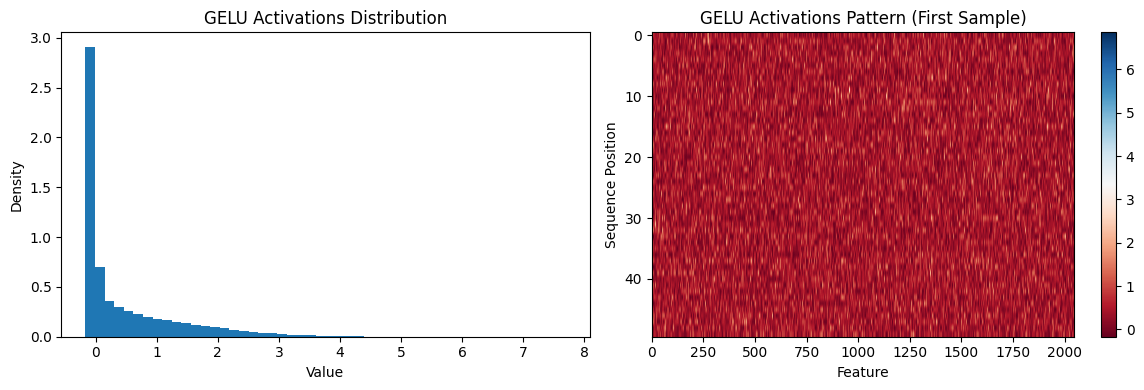

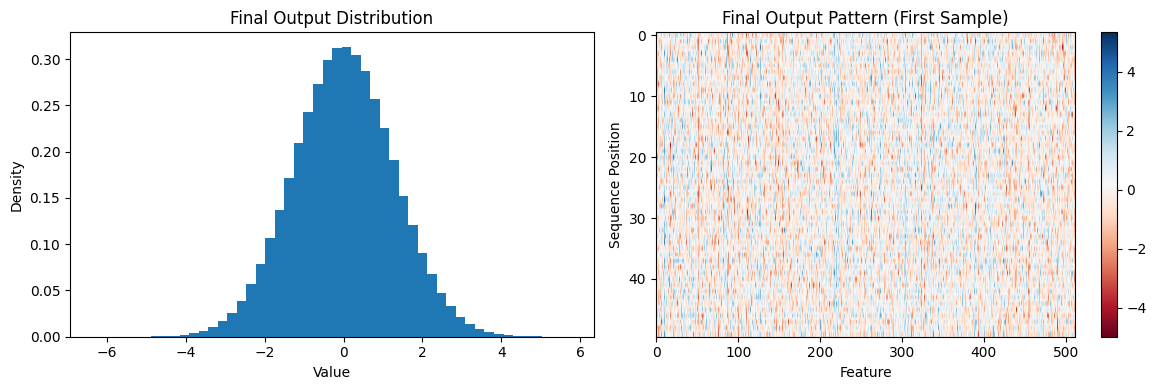

INFO:feedforward_debug:Starting backward pass



Backward Pass Statistics:
------------------------------

initial_gradient:
  mean: 0.0002
  std: 0.1000
  max: 0.4609
  min: -0.5086
  sparsity: 0.0000
  shape: (32, 50, 512)

dense2_gradient:
  mean: -0.0000
  std: 0.0632
  max: 0.3184
  min: -0.3121
  sparsity: 0.0000
  shape: (32, 50, 2048)

dropout_gradient:
  mean: -0.0000
  std: 0.0666
  max: 0.3359
  min: -0.3468
  sparsity: 0.0999
  shape: (32, 50, 2048)

activation_gradient:
  mean: -0.0000
  std: 0.0466
  max: 0.3745
  min: -0.3914
  sparsity: 0.1008
  shape: (32, 50, 2048)

final_gradient:
  mean: 0.0002
  std: 0.1317
  max: 0.6954
  min: -0.7515
  sparsity: 0.0000
  shape: (32, 50, 512)


In [5]:
class DebugFeedForward(FeedForward):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("feedforward_debug")
        self.debug_info = {}
        self.cached_tensors = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def analyze_tensor(self, tensor: np.ndarray, name: str) -> Dict:
        self.cached_tensors[name] = tensor.copy()
        
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'sparsity': float(np.mean(np.abs(tensor) < 1e-6)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats
        
    def visualize_activations(self, name: str, title: str) -> None:
        if name not in self.cached_tensors:
            self.logger.error(f"No cached tensor found for {name}")
            return
            
        tensor = self.cached_tensors[name]
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(tensor.flatten(), bins=50, density=True)
        plt.title(f'{title} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        
        plt.subplot(1, 2, 2)
        plt.imshow(tensor[0], aspect='auto', cmap='RdBu')
        plt.colorbar()
        plt.title(f'{title} Pattern (First Sample)')
        plt.xlabel('Feature')
        plt.ylabel('Sequence Position')
        
        plt.tight_layout()
        plt.show()
        
    def forward_pass(self, input_data: np.ndarray, training: bool = True) -> np.ndarray:
        self.logger.info("Starting forward pass")
        
        self.analyze_tensor(input_data, 'input')
        self.check_numerical_stability(input_data, 'input')
        
        x = self.dense1.forward_pass(input_data)
        self.analyze_tensor(x, 'dense1_output')
        self.check_numerical_stability(x, 'dense1_output')
        
        x = self.activation.forward_pass(x)
        act_stats = self.analyze_tensor(x, 'activation_output')
        self.check_numerical_stability(x, 'activation_output')
        
        self.logger.debug(f"Activation statistics: mean={act_stats['mean']:.4f}, "
                         f"std={act_stats['std']:.4f}, "
                         f"sparsity={act_stats['sparsity']:.4f}")
        
        if training:
            x = self.dropout.forward_pass(x, training=True)
            self.analyze_tensor(x, 'dropout_output')
            self.check_numerical_stability(x, 'dropout_output')
        
        x = self.dense2.forward_pass(x)
        self.analyze_tensor(x, 'output')
        self.check_numerical_stability(x, 'output')
        
        return x
        
    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting backward pass")
        
        self.analyze_tensor(output_error, 'initial_gradient')
        self.check_numerical_stability(output_error, 'initial_gradient')
        
        dx = self.dense2.backward_pass(output_error)
        self.analyze_tensor(dx, 'dense2_gradient')
        self.check_numerical_stability(dx, 'dense2_gradient')
        
        dx = self.dropout.backward_pass(dx)
        self.analyze_tensor(dx, 'dropout_gradient')
        self.check_numerical_stability(dx, 'dropout_gradient')
        
        dx = self.activation.backward_pass(dx)
        self.analyze_tensor(dx, 'activation_gradient')
        self.check_numerical_stability(dx, 'activation_gradient')
        
        dx = self.dense1.backward_pass(dx)
        self.analyze_tensor(dx, 'final_gradient')
        self.check_numerical_stability(dx, 'final_gradient')
        
        return dx

def debug_feedforward(
    d_model: int = 512,
    d_ff: int = 2048,
    batch_size: int = 32,
    seq_length: int = 50,
    visualize: bool = True
) -> None:
    print("\nDebugging FeedForward Layer")
    print("=" * 50)
    
    rng = np.random.default_rng(42)
    
    ff = DebugFeedForward(
        d_ff=d_ff,
        d_model=d_model,
        dropout_rate=0.1,
        activation='gelu'
    )
    
    input_data = rng.normal(0, 1, (batch_size, seq_length, d_model))
    
    output = ff.forward_pass(input_data, training=True)
    
    print("\nForward Pass Statistics:")
    print("-" * 30)
    for name, stats in ff.debug_info.items():
        if 'gradient' not in name:  # Only print forward pass stats here
            print(f"\n{name}:")
            for metric, value in stats.items():
                if metric != 'shape':
                    print(f"  {metric}: {value:.4f}")
                else:
                    print(f"  {metric}: {value}")
    
    if visualize:
        ff.visualize_activations('activation_output', 'GELU Activations')
        ff.visualize_activations('output', 'Final Output')
        
    output_grad = rng.normal(0, 0.1, output.shape)
    dx = ff.backward_pass(output_grad)
    
    print("\nBackward Pass Statistics:")
    print("-" * 30)
    gradient_keys = [k for k in ff.debug_info.keys() if 'gradient' in k]
    for key in gradient_keys:
        print(f"\n{key}:")
        for metric, value in ff.debug_info[key].items():
            if metric != 'shape':
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
                
    return ff

ff_debug = debug_feedforward(
    d_model=512,
    d_ff=2048,
    batch_size=32,
    seq_length=50,
    visualize=True
)

INFO:addnorm_debug:Starting forward pass



Debugging AddNorm Layer

Forward Pass Statistics:
------------------------------

main_input:
  mean: -0.0005
  std: 1.0005
  max: 5.0072
  min: -4.9282
  shape: (32, 50, 512)

residual_input:
  mean: 0.0002
  std: 0.1000
  max: 0.4609
  min: -0.5086
  shape: (32, 50, 512)

combined_input:
  mean: -0.0003
  std: 1.0056
  max: 5.0032
  min: -4.8547
  shape: (32, 50, 512)

gamma:
  mean: 1.0035
  std: 0.0500
  max: 1.1393
  min: 0.8295
  shape: (1, 1, 512)

beta:
  mean: -0.0002
  std: 0.0099
  max: 0.0294
  min: -0.0301
  shape: (1, 1, 512)

normalized:
  mean: 0.0000
  std: 0.9990
  max: 4.9727
  min: -4.7480
  shape: (32, 50, 512)
  mean_of_means: 0.0000
  mean_of_stds: 0.9990

output:
  mean: -0.0002
  std: 1.0038
  max: 5.4800
  min: -5.2350
  shape: (32, 50, 512)


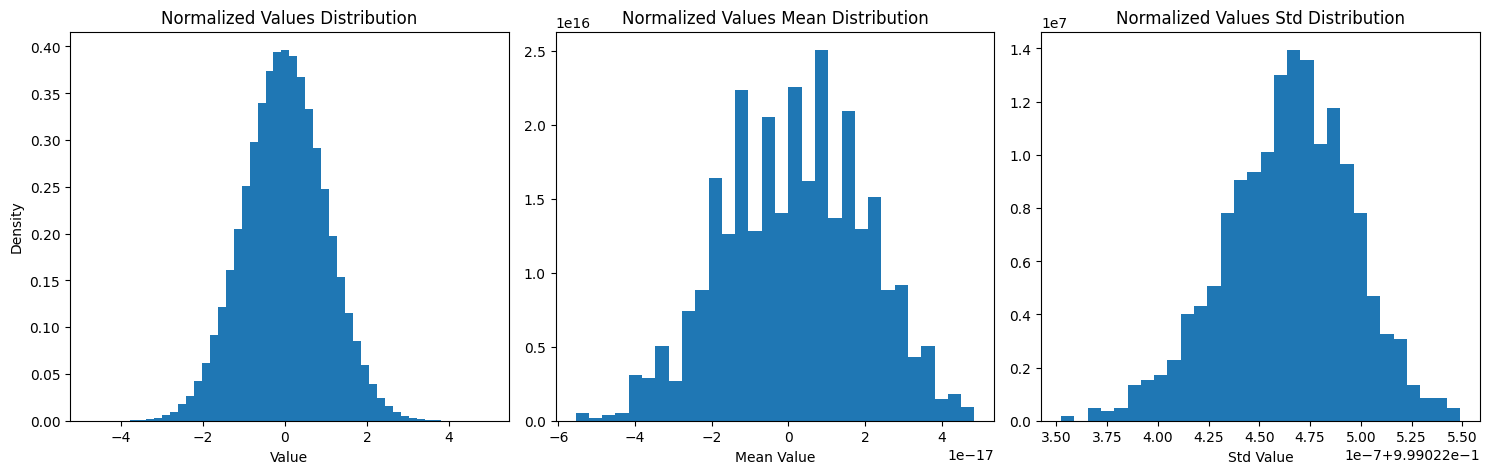

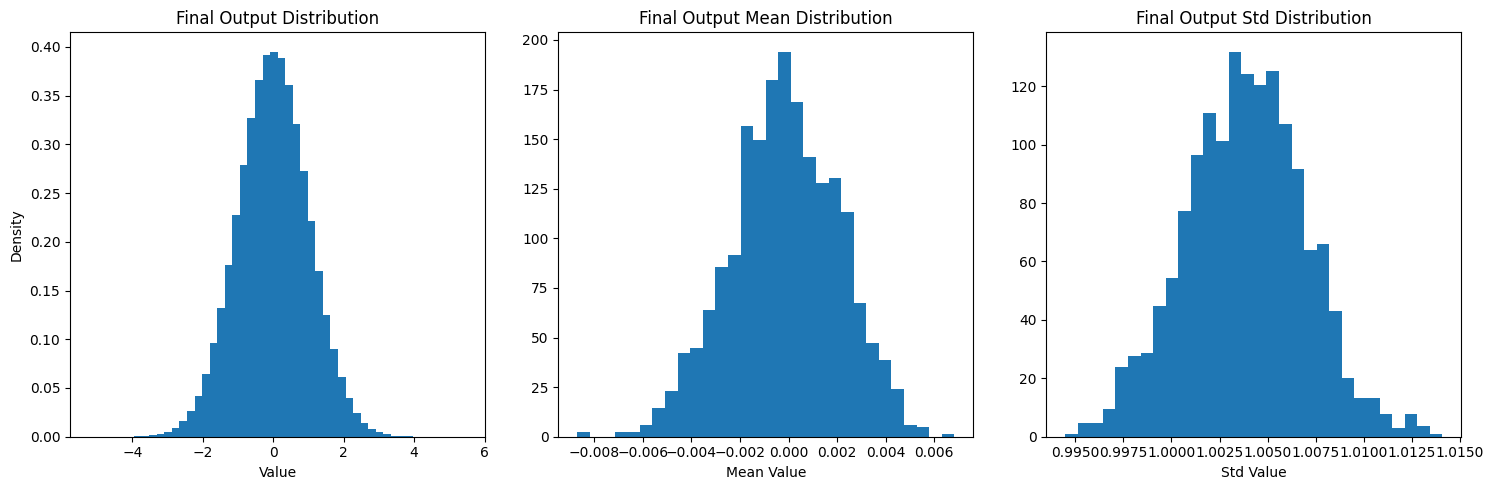

INFO:addnorm_debug:Starting backward pass



Backward Pass Statistics:
------------------------------

output_gradient:
  mean: 0.0000
  std: 0.1000
  max: 0.4704
  min: -0.5044
  shape: (32, 50, 512)

gamma_gradient:
  mean: -0.0689
  std: 4.1613
  max: 11.5446
  min: -9.3925
  shape: (1, 1, 512)

beta_gradient:
  mean: 0.0357
  std: 3.9425
  max: 11.1439
  min: -12.1071
  shape: (1, 1, 512)

input_gradient:
  mean: 0.0000
  std: 0.0999
  max: 0.5110
  min: -0.4570
  shape: (32, 50, 512)


In [6]:
class DebugAddNorm(AddNorm):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("addnorm_debug")
        self.debug_info = {}
        self.cached_tensors = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def analyze_tensor(self, tensor: np.ndarray, name: str) -> Dict:
        self.cached_tensors[name] = tensor.copy()
        
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        
        if 'normalized' in name:
            stats['mean_of_means'] = float(np.mean(np.mean(tensor, axis=-1)))
            stats['mean_of_stds'] = float(np.mean(np.std(tensor, axis=-1)))
            
        self.debug_info[name] = stats
        return stats
        
    def visualize_distribution(self, name: str, title: str) -> None:
        if name not in self.cached_tensors:
            self.logger.error(f"No cached tensor found for {name}")
            return
            
        tensor = self.cached_tensors[name]
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(tensor.flatten(), bins=50, density=True)
        plt.title(f'{title} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        
        plt.subplot(1, 3, 2)
        means = np.mean(tensor, axis=-1)
        plt.hist(means.flatten(), bins=30, density=True)
        plt.title(f'{title} Mean Distribution')
        plt.xlabel('Mean Value')
        
        plt.subplot(1, 3, 3)
        stds = np.std(tensor, axis=-1)
        plt.hist(stds.flatten(), bins=30, density=True)
        plt.title(f'{title} Std Distribution')
        plt.xlabel('Std Value')
        
        plt.tight_layout()
        plt.show()
        
    def forward_pass(self, inputs: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
        self.logger.info("Starting forward pass")
        x, residual = inputs
        
        self.analyze_tensor(x, 'main_input')
        self.analyze_tensor(residual, 'residual_input')
        
        combined = x + residual
        self.analyze_tensor(combined, 'combined_input')
        
        if self.gamma is None:
            self.initialize_weights(combined.shape)
            self.analyze_tensor(self.gamma, 'gamma')
            self.analyze_tensor(self.beta, 'beta')
        
        self.mean = np.mean(combined, axis=-1, keepdims=True)
        self.var = np.var(combined, axis=-1, keepdims=True, ddof=1)
        
        std = np.sqrt(self.var + self.epsilon)
        self.normalized = (combined - self.mean) / std
        
        self.analyze_tensor(self.normalized, 'normalized')
        self.check_numerical_stability(self.normalized, 'normalized')
        
        self.std = std
        self.output_before_gamma = self.normalized
        
        output = self.gamma * self.normalized + self.beta
        self.analyze_tensor(output, 'output')
        self.check_numerical_stability(output, 'output')
        
        return output
        
    def backward_pass(self, output_error: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        self.logger.info("Starting backward pass")
        
        self.analyze_tensor(output_error, 'output_gradient')
        
        N = output_error.shape[-1]
        
        self.d_gamma = np.sum(output_error * self.output_before_gamma, axis=(0, 1), keepdims=True)
        self.d_beta = np.sum(output_error, axis=(0, 1), keepdims=True)
        
        self.analyze_tensor(self.d_gamma, 'gamma_gradient')
        self.analyze_tensor(self.d_beta, 'beta_gradient')
        
        d_normalized = output_error * self.gamma
        d_variance = -0.5 * np.sum(d_normalized * self.output_before_gamma, 
                                 axis=-1, keepdims=True) / self.std
        d_mean = -np.sum(d_normalized / self.std, axis=-1, keepdims=True)
        
        d_input = (d_normalized / self.std + 
                  2.0 * d_variance * self.output_before_gamma / N +
                  d_mean / N)
                  
        self.analyze_tensor(d_input, 'input_gradient')
        self.check_numerical_stability(d_input, 'input_gradient')
        
        return d_input, d_input

def debug_addnorm(
    batch_size: int = 32,
    seq_length: int = 50,
    d_model: int = 512,
    visualize: bool = True
) -> None:
    print("\nDebugging AddNorm Layer")
    print("=" * 50)
    
    add_norm = DebugAddNorm(epsilon=1e-6)
    rng = np.random.default_rng(42)
    x = rng.normal(0, 1, (batch_size, seq_length, d_model))
    residual = rng.normal(0, 0.1, (batch_size, seq_length, d_model))
    
    # Forward pass
    output = add_norm.forward_pass((x, residual))
    
    print("\nForward Pass Statistics:")
    print("-" * 30)
    forward_keys = [k for k in add_norm.debug_info.keys() if 'gradient' not in k]
    for name in forward_keys:
        print(f"\n{name}:")
        for metric, value in add_norm.debug_info[name].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    if visualize:
        add_norm.visualize_distribution('normalized', 'Normalized Values')
        add_norm.visualize_distribution('output', 'Final Output')
        
    output_grad = rng.normal(0, 0.1, output.shape)
    dx, dr = add_norm.backward_pass(output_grad)
    
    print("\nBackward Pass Statistics:")
    print("-" * 30)
    gradient_keys = [k for k in add_norm.debug_info.keys() if 'gradient' in k]
    for key in gradient_keys:
        print(f"\n{key}:")
        for metric, value in add_norm.debug_info[key].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
                
    return add_norm

add_norm_debug = debug_addnorm(
    batch_size=32,
    seq_length=50,
    d_model=512,
    visualize=True
)

INFO:transformer_debug:Starting forward pass



Debugging Transformer Encoder Layer

Forward Pass Statistics:
------------------------------

input:
  mean: -0.0005
  std: 1.0005
  max: 5.0072
  min: -4.9282
  shape: (32, 50, 512)

attention_output:
  mean: 0.0002
  std: 0.2246
  max: 1.2061
  min: -1.1552
  shape: (32, 50, 512)

attention_dropout:
  mean: 0.0002
  std: 0.2368
  max: 1.3401
  min: -1.2836
  shape: (32, 50, 512)

attention_residual:
  main_norm: 0.1786
  residual_norm: 0.7979
  ratio: 4.4674

attention_norm:
  mean: -0.0001
  std: 1.0003
  max: 5.0951
  min: -4.7030
  shape: (32, 50, 512)

ffn_output:
  mean: 0.0001
  std: 0.5122
  max: 2.3452
  min: -2.5209
  shape: (32, 50, 512)

ffn_dropout:
  mean: 0.0000
  std: 0.5403
  max: 2.6058
  min: -2.8010
  shape: (32, 50, 512)

ffn_residual:
  main_norm: 0.4089
  residual_norm: 0.7980
  ratio: 1.9514

final_output:
  mean: 0.0004
  std: 1.0014
  max: 4.8545
  min: -5.2203
  shape: (32, 50, 512)


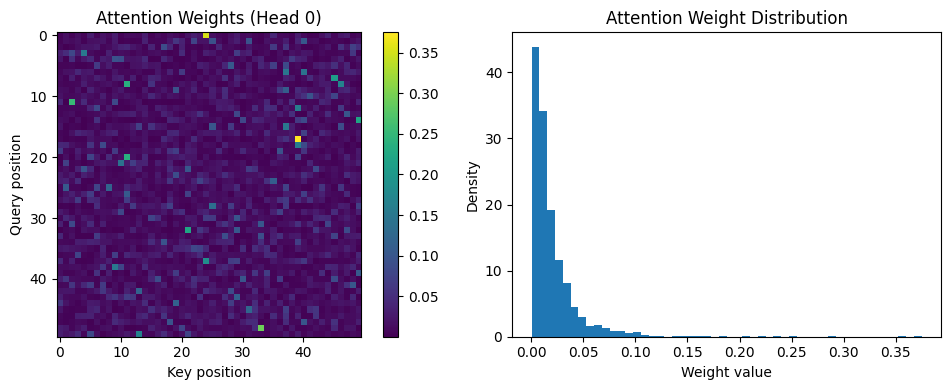

INFO:transformer_debug:Starting backward pass



Backward Pass Statistics:
------------------------------

initial_gradient:
  mean: 0.0002
  std: 0.1000
  max: 0.4609
  min: -0.5086
  shape: (32, 50, 512)

ffn_norm_gradient:
  mean: -0.0000
  std: 0.0880
  max: 0.4199
  min: -0.4377
  shape: (32, 50, 512)

ffn_norm_residual_gradient:
  mean: -0.0000
  std: 0.0880
  max: 0.4199
  min: -0.4377
  shape: (32, 50, 512)

combined_ffn_gradient:
  mean: -0.0000
  std: 0.1006
  max: 0.4973
  min: -0.4611
  shape: (32, 50, 512)

attention_norm_gradient:
  mean: 0.0000
  std: 0.0981
  max: 0.4659
  min: -0.4675
  shape: (32, 50, 512)

attention_norm_residual_gradient:
  mean: 0.0000
  std: 0.0981
  max: 0.4659
  min: -0.4675
  shape: (32, 50, 512)

attention_gradient:
  mean: 0.0000
  std: 0.0981
  max: 0.4650
  min: -0.4685
  shape: (32, 50, 512)


In [7]:
class DebugTransformerEncoderLayer(TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("transformer_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def visualize_attention(self, head_idx: int = 0) -> None:
        """Visualize attention patterns"""
        if not hasattr(self.attention, 'attention_weights'):
            self.logger.warning("No attention weights available")
            return
            
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        
        weights = self.attention.attention_weights[0, head_idx]
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'Attention Weights (Head {head_idx})')
        plt.xlabel('Key position')
        plt.ylabel('Query position')
        
        plt.subplot(1, 2, 2)
        plt.hist(weights.flatten(), bins=50, density=True)
        plt.title('Attention Weight Distribution')
        plt.xlabel('Weight value')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats

    def analyze_residual(self, main: np.ndarray, residual: np.ndarray, name: str) -> dict:
        main_norm = np.mean(np.abs(main))
        residual_norm = np.mean(np.abs(residual))
        ratio = residual_norm / (main_norm + 1e-8)

        stats = {
            'main_norm': float(main_norm),
            'residual_norm': float(residual_norm),
            'ratio': float(ratio)
        }
        self.debug_info[f'{name}_residual'] = stats
        return stats

    def forward_pass(self, inputs: np.ndarray, mask: np.ndarray = None, training: bool = True) -> np.ndarray:
        self.logger.info("Starting forward pass")
        
        self.analyze_tensor(inputs, 'input')
        self.check_numerical_stability(inputs, 'input')

        attn_output = self.attention.forward_pass(inputs, mask=mask, training=training)
        self.analyze_tensor(attn_output, 'attention_output')
        self.check_numerical_stability(attn_output, 'attention_output')

        if training:
            attn_output = self.attention_dropout.forward_pass(attn_output, training=training)
            self.analyze_tensor(attn_output, 'attention_dropout')

        self.analyze_residual(attn_output, inputs, 'attention')
        attn_output = self.attention_norm.forward_pass((attn_output, inputs))
        self.analyze_tensor(attn_output, 'attention_norm')

        ffn_output = self.ffn.forward_pass(attn_output, training=training)
        self.analyze_tensor(ffn_output, 'ffn_output')
        self.check_numerical_stability(ffn_output, 'ffn_output')

        if training:
            ffn_output = self.ffn_dropout.forward_pass(ffn_output, training=training)
            self.analyze_tensor(ffn_output, 'ffn_dropout')

        self.analyze_residual(ffn_output, attn_output, 'ffn')
        output = self.ffn_norm.forward_pass((ffn_output, attn_output))
        self.analyze_tensor(output, 'final_output')

        return output

    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting backward pass")
        self.analyze_tensor(output_error, 'initial_gradient')

        ffn_norm_dx, ffn_norm_dresidual = self.ffn_norm.backward_pass(output_error)
        self.analyze_tensor(ffn_norm_dx, 'ffn_norm_gradient')
        self.analyze_tensor(ffn_norm_dresidual, 'ffn_norm_residual_gradient')

        ffn_dx = self.ffn_dropout.backward_pass(ffn_norm_dx)
        ffn_dx = self.ffn.backward_pass(ffn_dx) + ffn_norm_dresidual
        self.analyze_tensor(ffn_dx, 'combined_ffn_gradient')

        attn_norm_dx, attn_norm_dresidual = self.attention_norm.backward_pass(ffn_dx)
        self.analyze_tensor(attn_norm_dx, 'attention_norm_gradient')
        self.analyze_tensor(attn_norm_dresidual, 'attention_norm_residual_gradient')

        attn_dx = self.attention_dropout.backward_pass(attn_norm_dx)
        attn_dx = self.attention.backward_pass(attn_dx) + attn_norm_dresidual
        self.analyze_tensor(attn_dx, 'attention_gradient')

        return attn_dx

def debug_transformer_layer(
    d_model: int = 512,
    num_heads: int = 8,
    d_ff: int = 2048,
    seq_length: int = 50,
    batch_size: int = 32,
    visualize: bool = True
) -> None:
    print("\nDebugging Transformer Encoder Layer")
    print("=" * 50)
    
    # Create layer
    layer = DebugTransformerEncoderLayer(
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        dropout_rate=0.1,
        attention_dropout=0.1
    )
    
    rng = np.random.default_rng(42)
    inputs = rng.normal(0, 1, (batch_size, seq_length, d_model))
    
    output = layer.forward_pass(inputs, training=True)
    
    print("\nForward Pass Statistics:")
    print("-" * 30)
    forward_keys = [k for k in layer.debug_info.keys() if 'gradient' not in k]
    
    for name in forward_keys:
        print(f"\n{name}:")
        stats = layer.debug_info[name]
        for metric, value in stats.items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    if visualize:
        layer.visualize_attention(head_idx=0)
        
    output_grad = rng.normal(0, 0.1, output.shape)
    dx = layer.backward_pass(output_grad)
    
    print("\nBackward Pass Statistics:")
    print("-" * 30)
    gradient_keys = [k for k in layer.debug_info.keys() if 'gradient' in k]
    
    for key in gradient_keys:
        print(f"\n{key}:")
        stats = layer.debug_info[key]
        for metric, value in stats.items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
                
    return layer

transformer_debug = debug_transformer_layer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    seq_length=50,
    batch_size=32,
    visualize=True
)

INFO:transformer_decoder_debug:Starting decoder forward pass



Debugging Transformer Decoder Layer

Forward Pass Statistics:
------------------------------

decoder_input:
  mean: -0.0005
  std: 1.0005
  max: 5.0072
  min: -4.9282
  shape: (32, 50, 512)

encoder_output:
  mean: 0.0019
  std: 0.9996
  max: 4.6093
  min: -5.0857
  shape: (32, 50, 512)

self_attention_output:
  mean: -0.0033
  std: 0.3918
  max: 4.6075
  min: -4.0509
  shape: (32, 50, 512)

self_attention_heads:
  head_0: {'entropy': 2.5687050337694926, 'sparsity': 0.9596125, 'mean_attention': 0.02, 'max_attention': 1.0}
  head_1: {'entropy': 2.5663177605006546, 'sparsity': 0.9595875, 'mean_attention': 0.02, 'max_attention': 1.0}
  head_2: {'entropy': 2.5569079703331394, 'sparsity': 0.9593125, 'mean_attention': 0.02, 'max_attention': 1.0}
  head_3: {'entropy': 2.5577614947352316, 'sparsity': 0.959275, 'mean_attention': 0.02, 'max_attention': 1.0}
  head_4: {'entropy': 2.5593481162284406, 'sparsity': 0.959825, 'mean_attention': 0.02, 'max_attention': 1.0}
  head_5: {'entropy': 2.5596

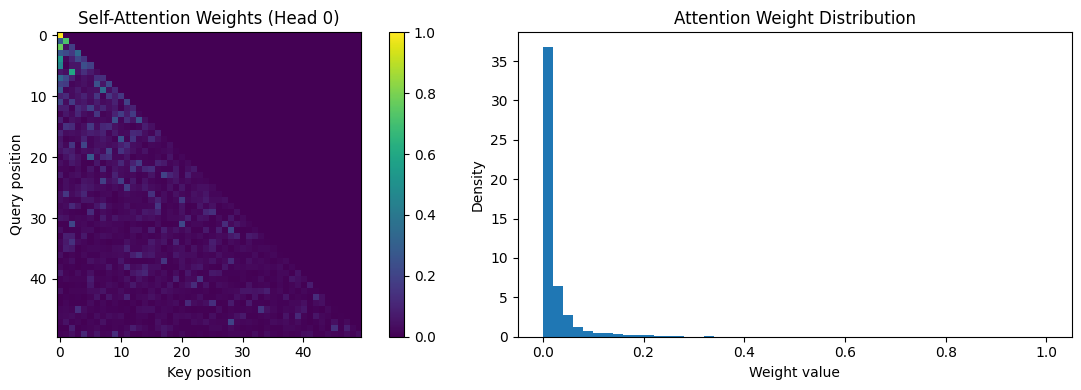


Visualizing Cross-Attention Pattern:


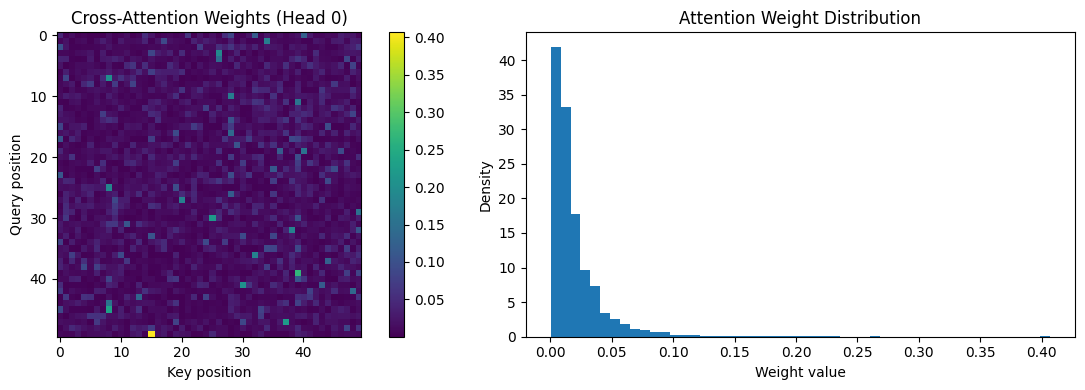

INFO:transformer_decoder_debug:Starting decoder backward pass



Backward Pass Statistics:
------------------------------

initial_gradient:
  mean: 0.0000
  std: 0.1000
  max: 0.4704
  min: -0.5044
  shape: (32, 50, 512)

ffn_norm_gradient:
  mean: 0.0000
  std: 0.0880
  max: 0.4253
  min: -0.4528
  shape: (32, 50, 512)

ffn_norm_residual_gradient:
  mean: 0.0000
  std: 0.0880
  max: 0.4253
  min: -0.4528
  shape: (32, 50, 512)

combined_ffn_gradient:
  mean: -0.0000
  std: 0.1007
  max: 0.5239
  min: -0.4889
  shape: (32, 50, 512)

cross_attention_norm_gradient:
  mean: 0.0000
  std: 0.0979
  max: 0.4871
  min: -0.4745
  shape: (32, 50, 512)

cross_attention_norm_residual_gradient:
  mean: 0.0000
  std: 0.0979
  max: 0.4871
  min: -0.4745
  shape: (32, 50, 512)

cross_attention_query_gradient:
  mean: 0.0000
  std: 0.0011
  max: 0.0068
  min: -0.0068
  shape: (32, 50, 512)

cross_attention_key_gradient:
  mean: -0.0000
  std: 0.0011
  max: 0.0083
  min: -0.0076
  shape: (32, 50, 512)

cross_attention_value_gradient:
  mean: -0.0000
  std: 0.0011


In [8]:
class DebugTransformerDecoderLayer(TransformerDecoderLayer):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("transformer_decoder_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def visualize_attention(self, attention_type: str = "self", head_idx: int = 0) -> None:
        attention = self.self_attention if attention_type == "self" else self.cross_attention
        
        if not hasattr(attention, 'attention_weights'):
            self.logger.warning(f"No {attention_type}-attention weights available")
            return
            
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        
        weights = attention.attention_weights[0, head_idx]
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'{attention_type.capitalize()}-Attention Weights (Head {head_idx})')
        plt.xlabel('Key position')
        plt.ylabel('Query position')
        
        plt.subplot(1, 2, 2)
        plt.hist(weights.flatten(), bins=50, density=True)
        plt.title('Attention Weight Distribution')
        plt.xlabel('Weight value')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats

    def analyze_residual(self, main: np.ndarray, residual: np.ndarray, name: str) -> dict:
        main_norm = np.mean(np.abs(main))
        residual_norm = np.mean(np.abs(residual))
        ratio = residual_norm / (main_norm + 1e-8)

        stats = {
            'main_norm': float(main_norm),
            'residual_norm': float(residual_norm),
            'ratio': float(ratio)
        }
        self.debug_info[f'{name}_residual'] = stats
        return stats

    def analyze_attention_heads(self, attention_type: str) -> dict:
        attention = self.self_attention if attention_type == "self" else self.cross_attention
        if not hasattr(attention, 'attention_weights'):
            return {}

        weights = attention.attention_weights
        head_stats = {}
        
        for head in range(self.num_heads):
            head_weights = weights[:, head]
            entropy = -np.sum(head_weights * np.log(head_weights + 1e-10), axis=-1).mean()
            sparsity = np.mean((head_weights < 0.1).astype(float))
            
            head_stats[f'head_{head}'] = {
                'entropy': float(entropy),
                'sparsity': float(sparsity),
                'mean_attention': float(np.mean(head_weights)),
                'max_attention': float(np.max(head_weights))
            }
            
        self.debug_info[f'{attention_type}_attention_heads'] = head_stats
        return head_stats

    def forward_pass(self, x: np.ndarray, enc_output: np.ndarray, 
                    training: bool = True, 
                    self_attention_mask: np.ndarray = None,
                    cross_attention_mask: np.ndarray = None) -> np.ndarray:
        self.logger.info("Starting decoder forward pass")
        
        self.analyze_tensor(x, 'decoder_input')
        self.analyze_tensor(enc_output, 'encoder_output')
        self.check_numerical_stability(x, 'decoder_input')
        self.check_numerical_stability(enc_output, 'encoder_output')

        attn1 = self.self_attention.forward_pass(x, mask=self_attention_mask, training=training)
        self.analyze_tensor(attn1, 'self_attention_output')
        self.check_numerical_stability(attn1, 'self_attention_output')
        self.analyze_attention_heads('self')

        if training:
            attn1 = self.dropout1.forward_pass(attn1, training=True)
            self.analyze_tensor(attn1, 'self_attention_dropout')

        self.analyze_residual(attn1, x, 'self_attention')
        out1 = self.norm1.forward_pass((attn1, x))
        self.analyze_tensor(out1, 'self_attention_norm')

        attn2 = self.cross_attention.forward_pass(
            (out1, enc_output, enc_output),
            mask=cross_attention_mask,
            training=training
        )
        self.analyze_tensor(attn2, 'cross_attention_output')
        self.check_numerical_stability(attn2, 'cross_attention_output')
        self.analyze_attention_heads('cross')

        if training:
            attn2 = self.dropout2.forward_pass(attn2, training=True)
            self.analyze_tensor(attn2, 'cross_attention_dropout')

        self.analyze_residual(attn2, out1, 'cross_attention')
        out2 = self.norm2.forward_pass((attn2, out1))
        self.analyze_tensor(out2, 'cross_attention_norm')

        ffn_out = self.ffn.forward_pass(out2, training=training)
        self.analyze_tensor(ffn_out, 'ffn_output')
        self.check_numerical_stability(ffn_out, 'ffn_output')

        if training:
            ffn_out = self.dropout3.forward_pass(ffn_out, training=True)
            self.analyze_tensor(ffn_out, 'ffn_dropout')

        self.analyze_residual(ffn_out, out2, 'ffn')
        out3 = self.norm3.forward_pass((ffn_out, out2))
        self.analyze_tensor(out3, 'final_output')

        return out3

    def backward_pass(self, output_error: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        self.logger.info("Starting decoder backward pass")
        self.analyze_tensor(output_error, 'initial_gradient')

        d_norm3, d_residual3 = self.norm3.backward_pass(output_error)
        self.analyze_tensor(d_norm3, 'ffn_norm_gradient')
        self.analyze_tensor(d_residual3, 'ffn_norm_residual_gradient')

        d_ffn = self.dropout3.backward_pass(d_norm3)
        d_ffn = self.ffn.backward_pass(d_ffn) + d_residual3
        self.analyze_tensor(d_ffn, 'combined_ffn_gradient')

        d_norm2, d_residual2 = self.norm2.backward_pass(d_ffn)
        self.analyze_tensor(d_norm2, 'cross_attention_norm_gradient')
        self.analyze_tensor(d_residual2, 'cross_attention_norm_residual_gradient')

        d_attn2 = self.dropout2.backward_pass(d_norm2)
        d_query2, d_key2, d_value2 = self.cross_attention.backward_pass(d_attn2)
        self.analyze_tensor(d_query2, 'cross_attention_query_gradient')
        self.analyze_tensor(d_key2, 'cross_attention_key_gradient')
        self.analyze_tensor(d_value2, 'cross_attention_value_gradient')

        d_norm1, d_residual1 = self.norm1.backward_pass(d_query2 + d_residual2)
        self.analyze_tensor(d_norm1, 'self_attention_norm_gradient')
        self.analyze_tensor(d_residual1, 'self_attention_norm_residual_gradient')

        d_attn1 = self.dropout1.backward_pass(d_norm1)
        d_x = self.self_attention.backward_pass(d_attn1) + d_residual1
        self.analyze_tensor(d_x, 'self_attention_gradient')

        return d_x, d_key2 + d_value2


def debug_transformer_decoder(
    d_model: int = 512,
    num_heads: int = 8,
    d_ff: int = 2048,
    seq_length: int = 50,
    batch_size: int = 32,
    visualize: bool = True
) -> None:
    print("\nDebugging Transformer Decoder Layer")
    print("=" * 50)
    
    # Create layer
    layer = DebugTransformerDecoderLayer(
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        dropout_rate=0.1,
        attention_dropout=0.1
    )
    
    rng = np.random.default_rng(42)
    decoder_input = rng.normal(0, 1, (batch_size, seq_length, d_model))
    encoder_output = rng.normal(0, 1, (batch_size, seq_length, d_model))
    
    self_attention_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype(bool)
    
    output = layer.forward_pass(
        decoder_input, 
        encoder_output,
        training=True,
        self_attention_mask=self_attention_mask
    )
    
    print("\nForward Pass Statistics:")
    print("-" * 30)
    forward_keys = [k for k in layer.debug_info.keys() if 'gradient' not in k]
    
    for name in forward_keys:
        print(f"\n{name}:")
        stats = layer.debug_info[name]
        if isinstance(stats, dict):
            for metric, value in stats.items():
                if isinstance(value, (int, float)):
                    print(f"  {metric}: {value:.4f}")
                else:
                    print(f"  {metric}: {value}")
    
    if visualize:
        print("\nVisualizing Self-Attention Pattern:")
        layer.visualize_attention("self", head_idx=0)
        print("\nVisualizing Cross-Attention Pattern:")
        layer.visualize_attention("cross", head_idx=0)
        
    # Backward pass
    output_grad = rng.normal(0, 0.1, output.shape)
    dx, denc = layer.backward_pass(output_grad)
    
    print("\nBackward Pass Statistics:")
    print("-" * 30)
    gradient_keys = [k for k in layer.debug_info.keys() if 'gradient' in k]
    
    for key in gradient_keys:
        print(f"\n{key}:")
        stats = layer.debug_info[key]
        for metric, value in stats.items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
                
    return layer

decoder_debug = debug_transformer_decoder(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    seq_length=50,
    batch_size=32,
    visualize=True
)